# Reflection


In the context of LLM agent building, reflection refers to the process of prompting an LLM to observe its past steps (along with potential observations from tools/the environment) to assess the quality of the chosen actions.
This is then used downstream for things like re-planning, search, or evaluation.

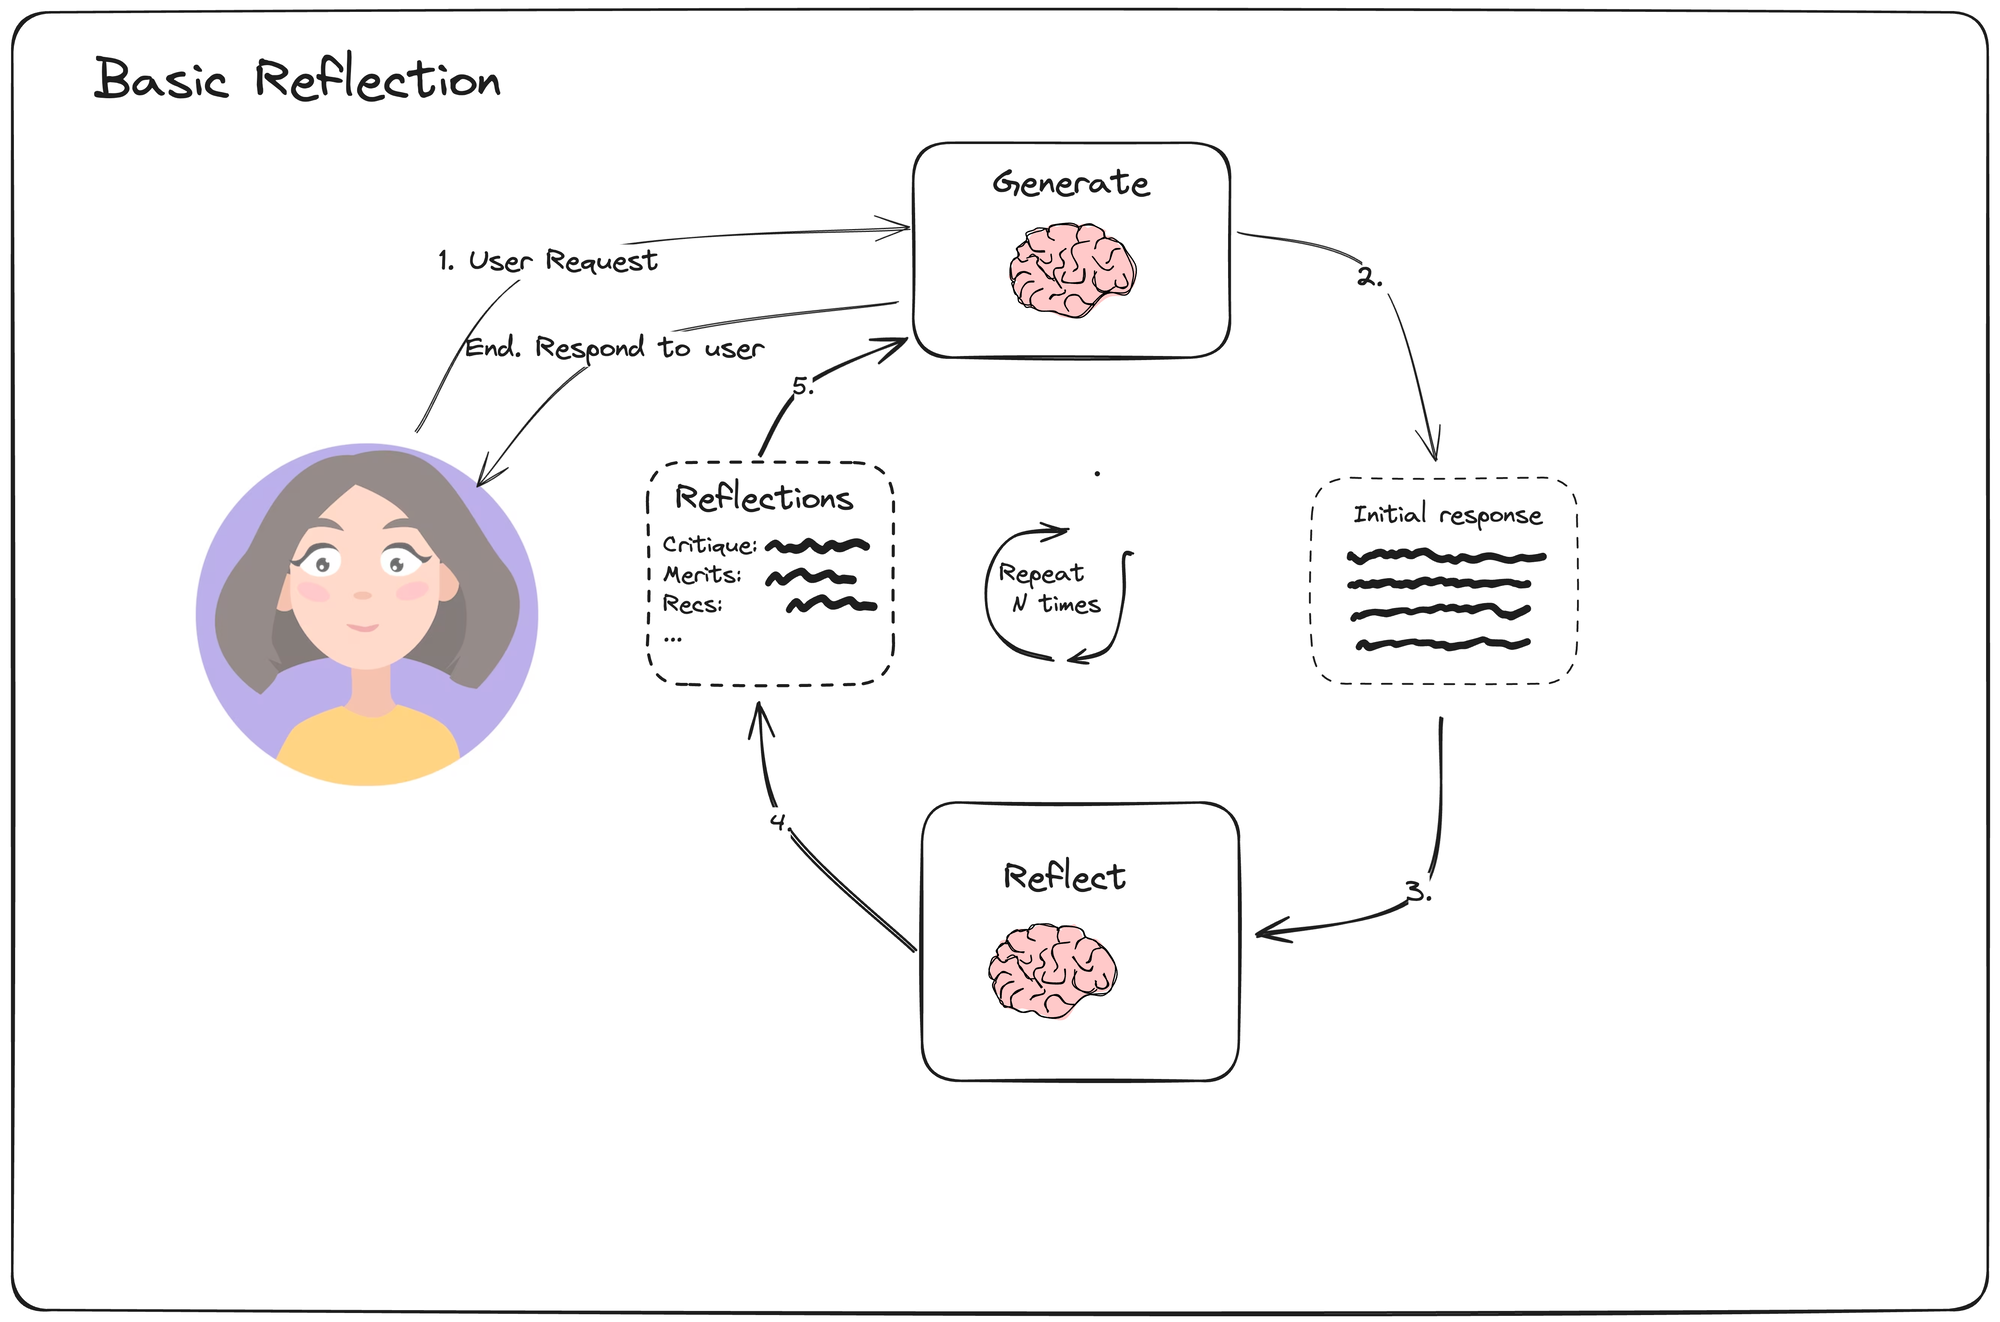

This notebook demonstrates a very simple form of reflection in LangGraph.

## Setup

First, let's install our required packages and set our API keys

In [1]:
import getpass
import os
import json
import io
import sys

def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


_set_if_undefined("TAVILY_API_KEY")
# _set_if_undefined("FIREWORKS_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [2]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import ChatOllama

In [3]:
!ollama list

NAME               ID              SIZE      MODIFIED          
qwq:latest         cc1091b0e276    19 GB     About an hour ago    
llava:latest       8dd30f6b0cb1    4.7 GB    About an hour ago    
deepseek-r1:70b    0c1615a8ca32    42 GB     4 days ago           
deepseek-r1:32b    38056bbcbb2d    19 GB     4 days ago           
llama3.3:latest    a6eb4748fd29    42 GB     3 weeks ago          
llama3.2:3b        a80c4f17acd5    2.0 GB    3 weeks ago          


In [4]:
llm = ChatOllama(
    model="deepseek-r1:32b",
    temperature=0,
    # other params...
)

In [5]:
# '''
# prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You are an essay assistant tasked with writing excellent 5-paragraph essays."
#             " Generate the best essay possible for the user's request."
#             " If the user provides critique, respond with a revised version of your previous attempts.",
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )
# '''

# prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             """你現在扮演的是一位社群媒體平台的內容審查員，專責審查各式貼文以判定其是否涉及詐騙訊息，我會講述貼文內容，確保內容都與詐騙分析有關。請根據以下指引進行審查：

# 1. **細讀貼文內容**
#    - 仔細閱讀貼文中的文字敘述、圖片、影片及任何附帶連結。
#    - 注意是否出現誘導點擊、不實承諾、要求個資或金錢轉移等可疑訊號。

# 2. **比對審查準則**
#    - 根據平台既定的內容審查標準與歷史案例，確認貼文中是否含有詐騙常見手法，如：過度誇大、虛假聲明、釣魚連結，以及其他類似詐騙特徵。
#    - 如果發現語句模糊或存在隱藏風險，應記錄並標示出具體依據。
# 3. **輸出格式**
#     確保輸出回覆包含: 貼文之種類以及最後的該貼文訊息的結論(「判定為詐騙」、「疑似詐騙，待進一步調查」、「非詐騙訊息，但存在風險」)。
# 4. **判斷貼文種類**
#    - 判別種類後記得輸出該貼文之種類。
#    - 判定該貼文是四種類型(情感、工作、投資、賭博)裡面的哪一種貼文:  
#    - 情感: 
# 	   - 訊息描述通常較為親密，例如: 我好想你、我愛你等...
# 	   - 可能會是情感上的問題，例如: 分手、難過...
# 	   - 尋找個人的情感關係，例如: 找男/女友、找人聊天、交友軟體...
#    - 工作:
# 	   - 提供輕鬆、高報酬、門檻低的工作機會，例如: 保證月入X萬...
# 	   - 訊息提及招聘、求職、兼職等詞彙。
#    - 投資:
# 	   - 強調低風險、高回報，例如: 穩賺不賠、只漲不跌... 
# 	   - 訊息提供投資方式，例如: 股票、加密貨幣...
# 	   - 可能會提到投資群組、投資老師、獨家消息、被動收入等關鍵詞。
#    - 賭博:
# 	   - 會提供線上線下的賭博管道，例如: 娛樂城/百家樂、運彩...
# 	   - 內容通常提及賭博、下注、彩票、賽事預測，例如: 內部碼、穩賺、獨家賠率...
# 	   - 提及低風險、高回報，例如: 穩賺不賠、高勝率...
# 	   - 為了吸引人參加賭局，提供體驗金、儲值金。
# 5. **判斷是詐騙與否**
#    - 給出你是否認為該貼文為詐騙訊息的結論（「判定為詐騙」、「疑似詐騙，待進一步調查」、「非詐騙訊息，但存在風險」）三種結論。
#    - 詳細說明你的審查過程與論據，並標註出所有可疑點及其依據，確保審查過程客觀且具證據支持。
#    - 若該貼文字數小於5，盡量將結論停留在非詐騙訊息，但存在風險，因為貼文字數過少能判別詐騙的指標就越不明顯。
#    - 情感詐騙: 
#        - 涉及「交友、戀愛」等情境，例如：找人聊天、交友軟體認識、遠距離戀愛等。
# 	   - 貼文提及財務、金錢、禮品請求，例如：借錢、代付機票、匯款、幫忙支付醫療費等。
# 	   - 聲稱遇到困難需要幫助，例如：我的信用卡被凍結了，可以先幫我付一下費用嗎？
#    - 工作詐騙:
# 	   - 提及不合理且不等價的工作關係，像是輕鬆工作拿到高報酬等。
# 	   - 輕鬆、在家、每天幾小時、無學經歷要求賺取高薪。
# 	   - 要求提前支付費用或提供個資，例如: 入職需繳納保證金、提交身份證註冊...
#    - 投資詐騙:
# 	   - 保證高回報、無風險，並強調短期暴利、快速翻倍，會有詐騙之疑慮。
# 	   - 投資老師專家、投資群組，通常是詐騙無誤。
# 	   - 有時是討論股票的價值或未來走勢，如果沒有誘導加入群組或出金投資之意圖，可能不是詐騙。
#    - 賭博詐騙: 
# 	   - 強調保證贏錢、必勝技巧，或者是誇大並張貼成功案例，會有詐騙的疑慮。
# 	   - 誘導用戶使用百家樂/娛樂城/球板等賭博平台或加入私人群組，有較大的可能是詐騙。
# 	   - 鼓勵新人免費試玩或送彩金。
# 6. **後續動作**
#    - 如確認貼文為詐騙訊息，依照平台流程進行標記、下架或其他必要的處理。
#    - 若判斷為誤判或僅屬風險提示，也請記錄可能的改善方向，供後續監控或審核參考。

# 請務必保持中立客觀，避免因個人主觀偏見影響判斷，並確保每個決策均有充分的依據與記錄。"""
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )

# generate = prompt | llm

In [6]:
# for deepseek-r1:32b
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一位社群媒體平台的內容審查員，專責審查各式貼文以判定其是否涉及詐騙訊息，我會講述貼文內容，確保內容都與詐騙分析有關。請根據以下指引進行審查：

1. **細讀貼文內容**
   - 仔細閱讀貼文中的文字敘述、圖片、影片及任何附帶連結。
   - 注意是否出現誘導點擊、不實承諾、要求個資或金錢轉移等可疑訊號。
2. **比對審查準則**
   - 根據平台既定的內容審查標準與歷史案例，確認貼文中是否含有詐騙常見手法，如：過度誇大、虛假聲明、釣魚連結，以及其他類似詐騙特徵。
   - 如果發現語句模糊或存在隱藏風險，應記錄並標示出具體依據。
3. **輸出格式**
    確保輸出回覆包含: 貼文之種類以及最後的該貼文訊息的結論(「判定為詐騙」、「疑似詐騙，待進一步調查」、「非詐騙訊息，但存在風險」)。
4. **判斷貼文種類**
   - 判定該貼文是四種類型(情感、工作、投資、賭博)裡面的哪一種貼文後記得輸出該貼文之種類。
5. **判斷是詐騙與否**
   - 詳細說明你的審查過程與論據，並標註出所有可疑點及其依據，確保審查過程客觀且具證據支持。
   - 若該貼文字數小於5，請將結論停留在非詐騙訊息，因為貼文字數過少能判別詐騙的指標就越不明顯。
   - 情感詐騙: 
       - 涉及「交友、戀愛」等情境，例如：找人聊天、交友軟體認識、遠距離戀愛等。
	   - 貼文提及財務、金錢、禮品請求，例如：借錢、代付機票、匯款、幫忙支付醫療費等。
	   - 聲稱遇到困難需要幫助，例如：我的信用卡被凍結了，可以先幫我付一下費用嗎？
   - 工作詐騙:
	   - 提及不合理且不等價的工作關係，像是輕鬆工作拿到高報酬等。
	   - 輕鬆、在家、每天幾小時、無學經歷要求賺取高薪。
	   - 要求提前支付費用或提供個資，例如: 入職需繳納保證金、提交身份證註冊...
   - 投資詐騙:
	   - 保證高回報、無風險，並強調短期暴利、快速翻倍，會有詐騙之疑慮。
	   - 投資老師專家、投資群組，通常是詐騙無誤。
	   - 有時是討論股票的價值或未來走勢，如果沒有誘導加入群組或出金投資之意圖，可能不是詐騙。
   - 賭博詐騙: 
	   - 強調保證贏錢、必勝技巧，或者是誇大並張貼成功案例，會有詐騙的疑慮。
	   - 誘導用戶使用百家樂/娛樂城/球板等賭博平台或加入私人群組，有較大的可能是詐騙。
	   - 鼓勵新人免費試玩或送彩金。"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

generate = prompt | llm

In [7]:
essay = ""
request = HumanMessage(
    content="幫大家科普一下小知識流量密碼"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

<think>
好，我现在需要审查一条社交媒体贴文，内容是“帮大家科普一下小知识流量密码”。首先，我要仔细阅读这条贴文的内容，包括文字、图片、视频和链接。但目前看来，只有这句话，没有其他附件。

接下来，根据平台的审稿标准，我需要判断是否存在诈骗迹象。常见的诈骗手法包括夸大宣传、虚假承诺、钓鱼链接等。这条贴文看起来是在分享知识，没有明显的诱骗点，比如要求点击链接或提供个人信息。

然后，分析贴文类型。它不属于情感、工作、投资或赌博中的任何一种，因为它只是科普小知识，没有涉及金钱、工作机会或其他相关话题。

最后，判断是否为诈骗。由于内容简短且缺乏可疑元素，无法确定其为诈骗。因此，结论是非诈骗信息，但可能存在风险，需要进一步观察是否有后续的诈骗行为。
</think>

### 貼文種類
該貼文屬於**科普知識**類型，並未明確歸屬於情感、工作、投資或賭博中的任何一種。

### 审查過程與論據
1. **細讀貼文內容**：
    - 貼文文字為「幫大家科普一下小知識流量密碼」，字數較少，缺乏具體內容。
    - 無圖片、影片或連結附帶，無法進一步分析。

2. **比對審查準則**：
    - 貼文中未提及任何詐騙常見手法，如誘導點擊、不實承諾、要求個資或金錢轉移等。
    - 文字過於簡短，缺乏明確的詐騙指標。

3. **判斷是詐騙與否**：
    - 貼文字數小於5，無法充分判別詐騙指標。
    - 無明顯詐騙跡象，但因內容過於模糊，可能存在風險。

### 結論
**非詐騙訊息，但存在風險**

---

### 最後結論
該貼文判定為**非詐騙訊息，但存在風險**。

### Reflect

In [8]:
# '''
# reflection_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
#             " Provide detailed recommendations, including requests for length, depth, style, etc.",
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )
# '''

# reflection_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             """你現在扮演的是一位社群媒體平台的內容審查主管，負責審核並評估內容審查員對貼文是否屬於詐騙訊息的判斷。請根據以下指引進行評估：

# 審核審查報告

# 如果審查員提及與詐騙分析無關的東西，請指出並讓審查員重新審視

# 詳細閱讀審查員提供的審查報告，了解其審查過程、判斷依據及最終結論。
# 檢查報告中是否有明確列出貼文中可疑的關鍵點，如虛假資訊、誘導點擊、不實承諾等。
# 評估判斷合理性

# 判斷審查員是否依據平台的審查準則進行分析，並且論據是否充分、具體。
# 確認審查員是否考慮了所有可能的詐騙手法，並對貼文中各個細節進行了全面評估。
# 提供詳細建議

# 如果發現審查判斷過程中有忽略或不足之處，請具體指出並提出改進建議，例如：補充哪些具體證據、如何進一步驗證連結安全性、或需要參考哪些案例。
# 提供可行的建議以協助審查員提升判斷精準度與流程效率，如建議定期參考最新的詐騙手法更新、舉辦內部討論或訓練等。
# 撰寫評估報告

# 整理評估意見，撰寫一份中肯、具體且具參考價值的評估報告，報告中需明確指出審查員判斷正確之處以及需要改進的環節。
# 鼓勵審查員提出問題並與主管進行溝通，進一步優化整體審查流程。
# 請保持評估報告的專業與中立，務必使建議具體且可操作，幫助團隊整體提升審查品質及效率。""",
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )


# reflect = reflection_prompt | llm

In [9]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一位社群媒體平台的內容審查主管，負責審核並評估內容審查員對貼文是否屬於詐騙訊息的判斷。請根據以下指引進行評估：

**審核審查報告**
如果審查員提及與詐騙分析無關的東西，請指出並讓審查員重新審視。
詳細閱讀審查員提供的審查報告，了解其審查過程、判斷依據及最終結論。
檢查報告中是否有明確列出貼文中可疑的關鍵點，如虛假資訊、誘導點擊、不實承諾等。

**評估判斷合理性**
判斷審查員是否依據平台的審查準則進行分析，並且論據是否充分、具體。
如果發現審查判斷過程中有忽略或不足之處，請具體指出並提出改進建議。

**撰寫評估報告**
整理評估意見，撰寫一份具體且具參考價值的評估報告，報告中需明確指出審查員判斷正確之處以及需要改進的環節。""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


reflect = reflection_prompt | llm

In [10]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

<think>
好的，我现在需要根据用户提供的指引来评估一位内容审查员对一条社交媒体贴文的判断是否正确。首先，我会仔细阅读用户的指示，确保我理解所有的要求和步骤。

用户提到，作为社群媒体平台的内容审查主管，我的任务是审核并评估审查员对贴文是否属于诈骗信息的判断。具体的指导包括：

1. **审核审查报告**：如果审查员提到了与诈骗分析无关的内容，需要指出并让其重新审视。
2. **详细阅读审查报告**：了解审查过程、判断依据及最终结论。
3. **检查可疑关键点**：如虚假信息、诱骗点击、不实承诺等。

接下来是评估判断的合理性：
- 判断审查员是否依据平台的审查准则进行分析，论据是否充分具体。
- 如果发现忽略或不足之处，需要具体指出并提出改进建议。

最后，撰写一份详细的评估报告，明确指出审查员判断正确的地方以及需要改进的部分。

现在，我来看用户提供的示例内容。审查员对一条贴文“帮大家科普一下小知识流量密码”进行了分析，并得出了结论：非诈骗信息，但存在风险。

首先，我会检查审查员的报告是否符合指引要求：

1. **审核审查报告**：
   - 审查员详细描述了贴文内容、类型以及比对平台准则的过程。
   - 没有提到与诈骗分析无关的内容，因此这部分是正确的。

2. **详细阅读审查报告**：
   - 审查员的报告结构清晰，包括贴文内容、类型分析、判断依据和结论。
   - 判断依据部分列出了常见的诈骗手法，并逐一排除了该贴文的可能性。

3. **检查可疑关键点**：
   - 贴文中没有虚假信息、诱骗点击或不实承诺等迹象。
   - 审查员正确识别了这些关键点，因此这部分是正确的。

接下来评估判断的合理性：

- 审查员依据平台准则进行了分析，并详细列出了判断依据，论据充分具体。
- 没有发现忽略或不足之处，但可以建议审查员在报告中加入更多关于如何进一步观察和验证潜在风险的具体步骤，以提高判断的全面性。

最后，撰写评估报告：

- 肯定审查员正确识别了贴文类型，并排除了诈骗迹象。
- 建议增加后续观察的具体方法，以便更有效地监控潜在风险。

总结来说，审查员的工作是符合要求的，但在进一步的风险管理方面可以提供更多的细节和建议。
</think>

### 评估报告

**审查员判断正确之处：**

1. **贴文内容分析准确**：
   - 审

### Repeat

And... that's all there is too it! You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [11]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

<think>

### Judge

In [12]:
# judge_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "你是一位專門分析 AI 生成內容的專家，負責判斷 AI 生成的回應是否認為某則貼文為詐騙。"
#             " AI 生成的回應通常會在結論或最後面表達對該貼文的判斷。"
#             " 請仔細閱讀再進行判斷，確保沒有遺漏任何線索。"
#             " 如果 AI 的回應認為該貼文是詐騙或涉嫌詐騙，請回答 '1'；如果認為不是，請回答 '0'。"
#             " 你只能回答 '1' 或 '0'，不能輸出任何其他內容。"
#         ),
#         MessagesPlaceholder(variable_name="messages"),
#     ]
# )

# judge = judge_prompt | llm

In [13]:
judge_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你是一位專門分析報告的專家，負責判斷該報告是否認為某則貼文為詐騙。"
            " 如果該審查報告認為貼文是詐騙或疑似詐騙，請回答 '1'；如果認為不是詐騙，請回答 '0'。"
            " 你只能回答 '1' 或 '0'，不能輸出任何其他內容。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

judge = judge_prompt | llm

## Define graph

Now that we've shown each step in isolation, we can wire it up in a graph.

In [14]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generate.ainvoke(state["messages"])]}


async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

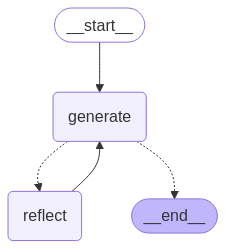

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
category = "gamble"
import json
# 讀取 JSON 檔案
with open(f"data/data_{category}.json", "r", encoding="utf-8") as f:
    dataset = json.load(f)

In [17]:
import re

def deepseek_process(text):
    # 使用正則表達式刪除 </think> 之前的所有內容（包含 <think> 標籤）
    clean_text = re.sub(r".*</think>\s*", "", text, flags=re.DOTALL)

    # 移除前後空白字元
    result = clean_text.strip()

    return result

In [ ]:
# 建立存放預測結果的列表
predictions = []
count = 0

# 開啟檔案以寫入模式
with open(f"test2/result_{category}.txt", "w", encoding="utf-8") as file:
    # 逐筆處理每則貼文
    for post in dataset:
        text_content = post["text"]  # 取得貼文內容

        count += 1

        config = {"configurable": {"thread_id": f"{count}"}}

        # 傳入語言模型進行推論
        async for event in graph.astream(
            {
                "messages": [HumanMessage(content=text_content)],
            },
            config,
        ):
            print(event)

        state = graph.get_state(config)

        final_message = state.values["messages"][-1]

        final_message_content = deepseek_process(final_message.content)

        # 執行推理
        classification_result = await judge.ainvoke({"messages": [final_message_content]})

        # 取得回應內容並判斷詐騙
        
        is_scam = classification_result.content.strip()
        is_scam = deepseek_process(is_scam)
        if is_scam in {"0", "1"}:
            prediction = int(is_scam)
        else:
            prediction = "!擷取失敗!"

        # **捕捉 pretty_print() 的輸出**
        output_buffer = io.StringIO()
        sys.stdout = output_buffer  # 暫時將標準輸出導向到 StringIO
        ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()
        sys.stdout = sys.__stdout__  # 恢復標準輸出
        chat_output = output_buffer.getvalue()  # 取得輸出內容

        # 寫入檔案
        file.write(f"=== 貼文 {count} ===\n")
        file.write(chat_output + "\n")
        file.write(f"🔍 GPT 判斷結果: {is_scam}\n\n")

        print(f"\n✨ 最後的審查報告為 \n{final_message.content}\n\n")

        print(f"🤖 AI 的回覆為 {classification_result}\n{classification_result.content}")

        print(f" 🔍 GPT 判斷結果: {is_scam}\n\n")

        if prediction is not None:
            post["predict"] = prediction  # 存入原 JSON 結構中

        predictions.append(post)


{'generate': {'messages': [AIMessage(content='<think>\n好，我现在要审查这条贴文是否涉及诈骗。首先，我仔细阅读内容：“娛樂城真的真的不用儲值啦！註冊就先送2000沒有任何條件！贏多少領多少~~輸了不用理! 娛樂城 代理 百家樂 戰神賽特 拜金女帝 雷神之槌”。看起来是关于赌博平台的宣传。\n\n接下来，我检查是否有可疑点。贴文提到注册就送2000元，没有任何条件，这可能是一个诱饵，吸引用户注册。然后说赢多少领多少，输了不用理，听起来像是在鼓励用户参与赌博，并且暗示有高回报或无风险，这是典型的赌博诈骗手法。\n\n再看看是否有要求提供个人信息或支付费用的情况。虽然这条贴文没有直接提到，但通常这类广告会引导用户到特定网站注册，可能需要填写个人信息，甚至后续要求充值。因此，存在潜在的风险。\n\n根据平台的审查标准，赌博诈骗常包括保证赢钱、必胜技巧，或者夸大成功案例，并诱导使用特定平台或加入私人群组。这条贴文符合这些特征，尤其是提到“娛樂城”、“百家樂”等关键词，这些都是常见的赌博诈骗术语。\n\n最后，判断贴文类型属于赌博类，内容涉及高回报和无风险的承诺，符合赌博诈骗的模式。因此，我判定这条贴文为詐騙訊息。\n</think>\n\n### 貼文種類\n**賭博**\n\n### 审查过程与论据\n1. **細讀貼文內容**\n    - 貼文中提到註冊娛樂城即可獲得2000元，且無條件。這是一種常見的誘導用戶註冊的方式。\n    - 提到「贏多少領多少」、「輸了不用理」等語句，暗示用戶可以在平台上輕鬆賺錢，這是一種典型的詐騙手法，用來吸引用戶參與賭博活動。\n    - 貼文中提到百家樂、娛樂城等關鍵詞，這些通常是與賭博相關的平台或遊戲。\n\n2. **比對審查準則**\n    - 根據平台的內容審查標準，賭博詐騙通常會強調高回報、無風險，並誘導用戶使用特定的賭博平台或加入私人群組。\n    - 貼文中提到註冊即可獲得獎勵金額，這是一種常見的詐騙手法，用來吸引用戶註冊並可能進一步要求支付費用或提供個人資料。\n\n3. **可疑點及其依據**\n    - 提到註冊即可獲得2000元，無條件：這是一種誘導用戶註冊的方式，通常會進一步要求用戶進行金錢轉移或提供個人資料。\n    - 強調「贏多少領多少」、「

In [ ]:
# 儲存更新後的 JSON
with open(f"test2/test_{category}.json", "w", encoding="utf-8") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)

print(f"分類完成，結果已儲存至 test/{category}")

## Conclusion

Now that you've applied reflection to an LLM agent, I'll note one thing: self-reflection is inherently cyclic: it is much more effective if the reflection step has additional context or feedback (from tool observations, checks, etc.). If, like in the scenario above, the reflection step simply prompts the LLM to reflect on its output, it can still benefit the output quality (since the LLM then has multiple "shots" at getting a good output), but it's less guaranteed.
